# Evaluación del caso “Sitnikov modificado con control de periodicidad”

Este notebook estudia una variante del problema de Sitnikov: dos estrellas de masas similares orbitan en el plano XY y un tercer cuerpo ligero se mueve a lo largo del eje Z. Ajustamos las masas mediante el pipeline híbrido (GA + refinamiento continuo) para buscar órbitas casi periódicas y con menor sensibilidad caótica medida mediante el exponente de Lyapunov.

> **Interpretación**
> - La penalización `periodicity_weight` fuerza que el estado final se acerque al inicial; un valor pequeño del fitness implica trayectoria casi repetitiva.
> - Comparar λ del centro del rango de masas contra el λ optimizado permite medir cuánto se estabiliza la dinámica vertical del tercer cuerpo.

## Preparación del entorno

Normalizamos la ruta raíz del proyecto y la insertamos en `sys.path` para que los imports funcionen sin importar desde qué carpeta se lance el notebook.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias y utilidades clave

Cargamos los componentes fundamentales del flujo:
- `Config` y utilidades de seeding para reproducibilidad.
- El `ContinuousOptimizationController`, visualizadores 2D/3D y el adaptador REBOUND base.
- `numpy` y `pathlib` para manejar resultados y artefactos en disco.


In [2]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path

## Instrumentación de rendimiento

Activamos trazas de tiempo a nivel de bloque (`time_block`) y preparamos utilidades para recuperar los CSV agregados. Esto permite auditar el costo de cada fase del pipeline directamente desde el notebook.

In [3]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


## Formato de logging para el notebook

Registramos un `logging.Handler` personalizado que acumula los mensajes y los muestra con `display(Markdown(...))`, manteniendo limpio el flujo de salida mientras corren las generaciones del GA.


In [4]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)  # aparece en la celda conforme avanza

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="DEBUG")
logger.handlers.clear()          # quita otros handlers previos
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)


## Configuración del escenario “Sitnikov modificado”

Definimos el diccionario `case` con:
- Integración a largo plazo (`t_end_long = 6000`, `dt = 0.08`) usando `whfast`.
- Condiciones iniciales simétricas para el binario y un tercer cuerpo con desplazamiento ligero en Y/Z.
- Límites estrechos para las masas estelares y un rango reducido para el tercer cuerpo.
- Penalización de periodicidad (`periodicity_weight = 0.08`) y presupuesto de evaluación amplio para que el GA explore soluciones estables.

In [5]:
case = {
    # Integración (UA, años, masas solares)
    "t_end_short": 0.5,            # ~6 órbitas de la binaria
    "t_end_long": 4.0,             # verificación en un horizonte de 2 años
    "dt": 2.0e-4,                  # ~0.18 días; estable para IAS15
    "integrator": "ias15",

    # Condiciones iniciales (Sitnikov físico)
    "r0": (
        (-0.5, 0.0, 0.0),          # estrellas separadas 1 UA
        (0.5, 0.0, 0.0),
        (0.0, 0.0, 0.04),          # planeta / partícula sobre el eje Z
    ),
    "v0": (
        (0.0, -4.442882938, 0.0),  # binaria circular (ω = √(G·2 / 1^3))
        (0.0, 4.442882938, 0.0),
        (0.0, 0.0, 0.90),          # impulso inicial para disparar el movimiento
    ),

    # Parámetros físicos
    "mass_bounds": (
        (0.8, 1.2),              # estrella 1 ~1 Msun
        (0.8, 1.2),              # estrella 2 ~1 Msun
        (2.5e-6, 5.0e-6),          # cuerpo pequeño tipo Tierra-Júpiter trozo
    ),
    "G": 39.47841760435743,        # 4*pi^2 en unidades astronómicas
    "periodicity_weight": 0.05,    # penaliza deriva moderada (Δr + Δv)

    # GA / búsqueda continua
    "pop_size": 180,
    "n_gen_step": 5,
    "crossover": 0.85,
    "mutation": 0.2,
    "elitism": 2,
    "seed": 1234,

    # Control de ejecución (prueba rápida)
    "max_epochs": 50,
    "top_k_long": 12,
    "stagnation_window": 5,
    "stagnation_tol": 1.25e-4,
    "local_radius": 0.04,
    "radius_decay": 0.85,
    "time_budget_s": 1800.0,
    "eval_budget": 16000,

    # Artefactos / salida
    "artifacts_dir": "artifacts/sitnikov_real",
    "save_plots": True,
    "headless": False,
}


In [6]:
from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

cfg = Config(**case)
logger = setup_logger()

## Adaptador especializado de REBOUND

Subclasamos `ReboundSim` para imponer la restricción de Sitnikov: tras cada paso, fijamos `x = vx = 0` del tercer cuerpo de modo que la partícula se mantenga sobre el eje Z. Mediante un monkeypatch temporal logramos que el `FitnessEvaluator` utilice este integrador personalizado durante todo el experimento.


In [7]:
import rebound

class SitnikovReboundSim(ReboundSim):
    def setup_simulation(self, *args, **kwargs):
        sim = super().setup_simulation(*args, **kwargs)

        def clamp(_sim_ptr=None):
            if len(sim.particles) > 2:
                particle = sim.particles[2]
                particle.x = 0.0
                particle.vx = 0.0

        sim.post_timestep_modifications = clamp
        return sim

# Monkeypatch para que FitnessEvaluator use el adaptador sitnikov
from two_body.simulation import rebound_adapter
rebound_adapter.ReboundSim = SitnikovReboundSim

c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((0.8, 1.2), (0.8, 1.2), (2.5e-06, 5e-06)) 50 16000


## Ejecución del controlador híbrido

Creamos la configuración, el `logger` y el `ContinuousOptimizationController`. Usamos `time_block("notebook_run")` para medir la ejecución completa (GA + refinamiento), registramos los eventos relevantes y recopilamos el mejor individuo encontrado.


In [9]:
with time_block("notebook_run", extra={"source": "Caso01.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-11-02 18:03:22,252] INFO - Starting optimization | pop=180 | dims=3 | time_budget=1800.0s | eval_budget=16000
[2025-11-02 18:03:35,304] INFO - Epoch 0 | new global best (short) lambda=-12.329815 | fitness=11.034798 | penalty=25.900326 | masses=(0.910586, 1.120749, 5e-06)
[2025-11-02 18:03:42,734] INFO - Epoch 0 complete | lambda_short=-12.329815 | fitness_short=11.034798 | lambda_best=-12.329815 | fitness_best=11.034798 | evals short/long=180/12 | total evals=192 | radius=0.0400
[2025-11-02 18:03:56,015] INFO - Epoch 1 | new global best (short) lambda=-12.831173 | fitness=11.453951 | penalty=27.544443 | masses=(0.801784, 1.161022, 4e-06)
[2025-11-02 18:04:03,206] INFO - Epoch 1 complete | lambda_short=-12.831173 | fitness_short=11.453951 | lambda_best=-12.831173 | fitness_best=11.453951 | evals short/long=180/12 | total evals=384 | radius=0.0400
[2025-11-02 18:04:24,257] INFO - Epoch 2 complete | lambda_short=-11.329133 | fitness_short=10.068536 | lambda_best=-12.831173 | fitness

## Métricas de referencia y resultado óptimo

Calculamos el fitness del centro de los intervalos (`center`) como línea base y lo comparamos con la solución óptima (`results["best"]`). También recuperamos `metrics` para inspeccionar la evolución de λ por época y cualquier otra estadística almacenada por el controlador.

In [10]:
metrics = controller.metrics
results

{'status': 'completed',
 'best': {'masses': [0.8191638121070504, 1.2, 2.5e-06],
  'lambda': -15.714886129963242,
  'fitness': 14.292218582279823,
  'm1': 0.8191638121070504,
  'm2': 1.2,
  'm3': 2.5e-06},
 'evals': 9600,
 'epochs': 50}

## Seguimiento de λ y reconstrucción de trayectorias

Visualizamos:
- La secuencia `metrics.best_lambda_per_epoch` y, opcionalmente, un suavizado para detectar tendencias.
- Las trayectorias 3D integradas con las masas óptimas (`viz_3d.animate_3d`) y cualquier proyección 2D rápida (`viz_planar.quick_view`) para confirmar la estabilidad obtenida.


In [11]:
from two_body.core.cache import HierarchicalCache
from two_body.logic.fitness import FitnessEvaluator

cache = HierarchicalCache()
evaluator = FitnessEvaluator(cache, cfg)

original_masses = (0.8, 1.2, 2.5e-6)  # o los valores que te interesen
center = original_masses
#center = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)

baseline_fits, baseline_details = evaluator.evaluate_batch(
    [center],
    horizon="long",
    return_details=True,
)
baseline_fit = baseline_fits[0]
baseline_lambda = baseline_details[0].get("lambda")
if baseline_lambda is None or not np.isfinite(baseline_lambda):
    baseline_lambda = -baseline_fit

best_payload = results.get("best", {})
best_fit = best_payload.get("fitness")
best_lambda = best_payload.get("lambda")
if best_lambda is None and best_fit is not None:
    best_lambda = -best_fit

print(
    f"lambda inicial = {baseline_lambda:.6f}, "
    f"lambda optimo = {best_lambda if best_lambda is not None else 'N/A'}"
)


lambda inicial = -0.984161, lambda optimo = -15.714886129963242


In [12]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
print("Trayectoria calculada con masas óptimas.")
print(traj.shape)
print(traj[-1])
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]


Trayectoria calculada con masas óptimas.
(20000, 3, 6)
[[-6.67448908e-02  5.85504566e-01 -1.93614735e-07 -5.29717281e+00
  -5.53192498e-01  3.53308421e-08]
 [ 4.55617540e-02 -3.99686140e-01  1.17620941e-07  3.61605193e+00
   3.77617569e-01 -2.88401495e-06]
 [ 3.57753801e-01 -3.13603497e-01  6.98282203e-03 -4.02073893e+00
   5.67702912e+00  1.37275048e+00]]


In [13]:
from two_body.scripts.demo_tierra import (
    summarize_trajectory,
    compute_total_energy,
    estimate_orbital_period,
)

summarize_trajectory(
    logger=logger,
    traj=traj,
    masses=best_masses,
    cfg=cfg,
)

[2025-11-02 18:21:42,150] INFO - Resumen de simulacion
[2025-11-02 18:21:42,150] INFO -   pasos=20000 | dt=0.000200 anos | duracion total=4.000 anos
[2025-11-02 18:21:42,150] INFO -   masas=(0.8191638121070504, 1.2, 2.5e-06) (M_sun) | G=39.478418
[2025-11-02 18:21:42,152] INFO -   centro de masa: desplazamiento maximo = 1.932e-15 UA
[2025-11-02 18:21:42,173] INFO -   cuerpo 0 -> radio[min, max]=[0.5831, 0.5943] UA | radio sigma=3.9460e-03 | velocidad media=5.3325 UA/ano
[2025-11-02 18:21:42,186] INFO -   cuerpo 1 -> radio[min, max]=[0.3981, 0.4057] UA | radio sigma=2.6938e-03 | velocidad media=3.6402 UA/ano
[2025-11-02 18:21:42,193] INFO -   cuerpo 2 -> radio[min, max]=[0.0185, 0.8236] UA | radio sigma=2.3487e-01 | velocidad media=11.4824 UA/ano
[2025-11-02 18:21:42,234] INFO -   energia total (media)=-1.958813e+01 | variacion relativa=1.632e-15
[2025-11-02 18:21:42,249] INFO -   periodo orbital estimado para la Tierra ~= 0.693836 anos
[2025-11-02 18:21:42,249] INFO -   error relativo 

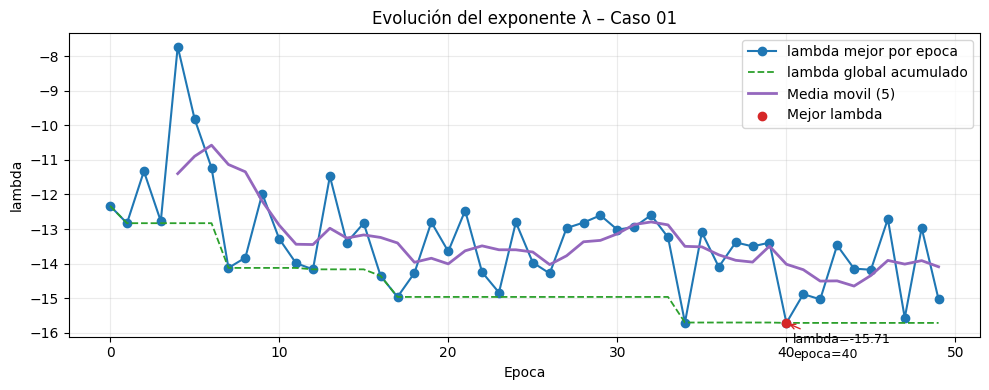

In [14]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 01",
    moving_average_window=5,   # opcional
)

In [15]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]

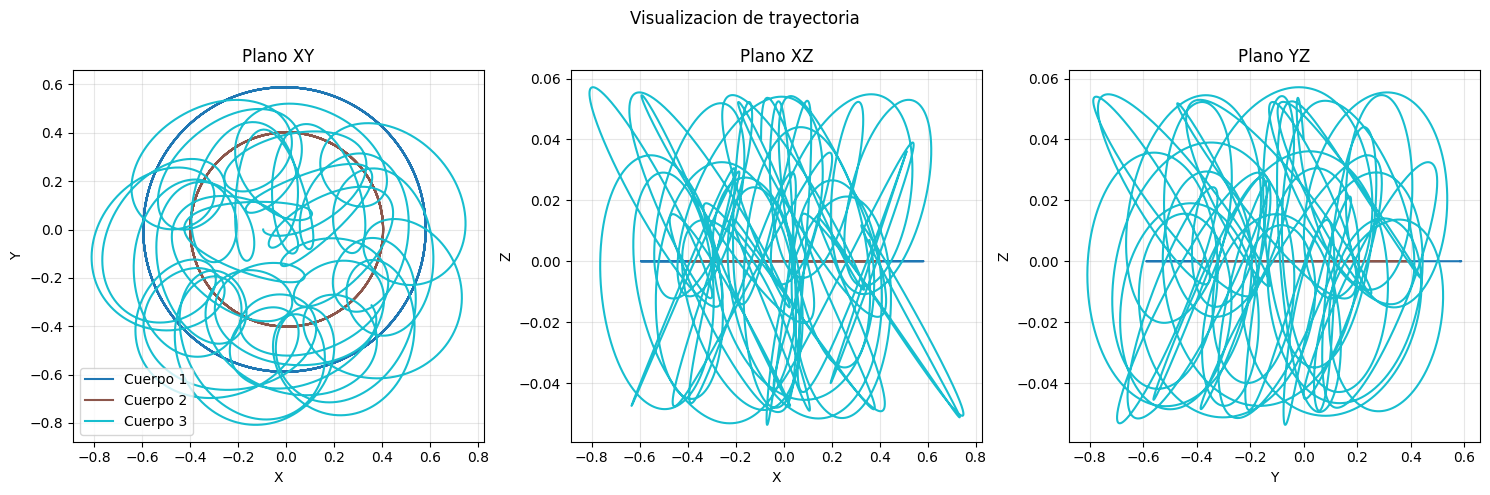

In [16]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks) 

In [17]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 1024  # MB

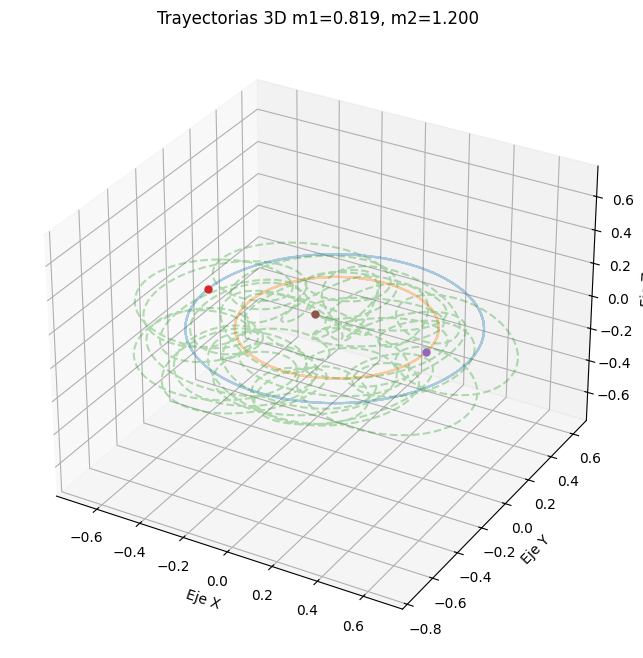

In [18]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks,
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

## Exportación de animaciones

Configuramos un `FFMpegWriter`, nos aseguramos de que el directorio `artifacts/caso02` exista y persistimos los MP4 de la trayectoria final y de la comparación de masas. Ajusta `fps`, `bitrate` o el preset de ffmpeg si necesitas reducir el tiempo de render.


In [19]:
from matplotlib.animation import FFMpegWriter  # o PillowWriter para GIF

writer = FFMpegWriter(fps=1000 // 50, bitrate=2400)   # fps = 1000/interval_ms
output_path = Path("artifacts/caso02")                # ajusta a tu gusto
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)

In [20]:
# Trayectoria con las masas originales (center)
sim_orig = sim_builder.setup_simulation(center, r0, v0)
traj_original = sim_builder.integrate(sim_orig, t_end=cfg.t_end_long, dt=cfg.dt)

# Si ya integraste con las masas óptimas, recicla ese resultado
traj_opt = traj  # 'traj' es la integración que acabas de calcular con best_masses


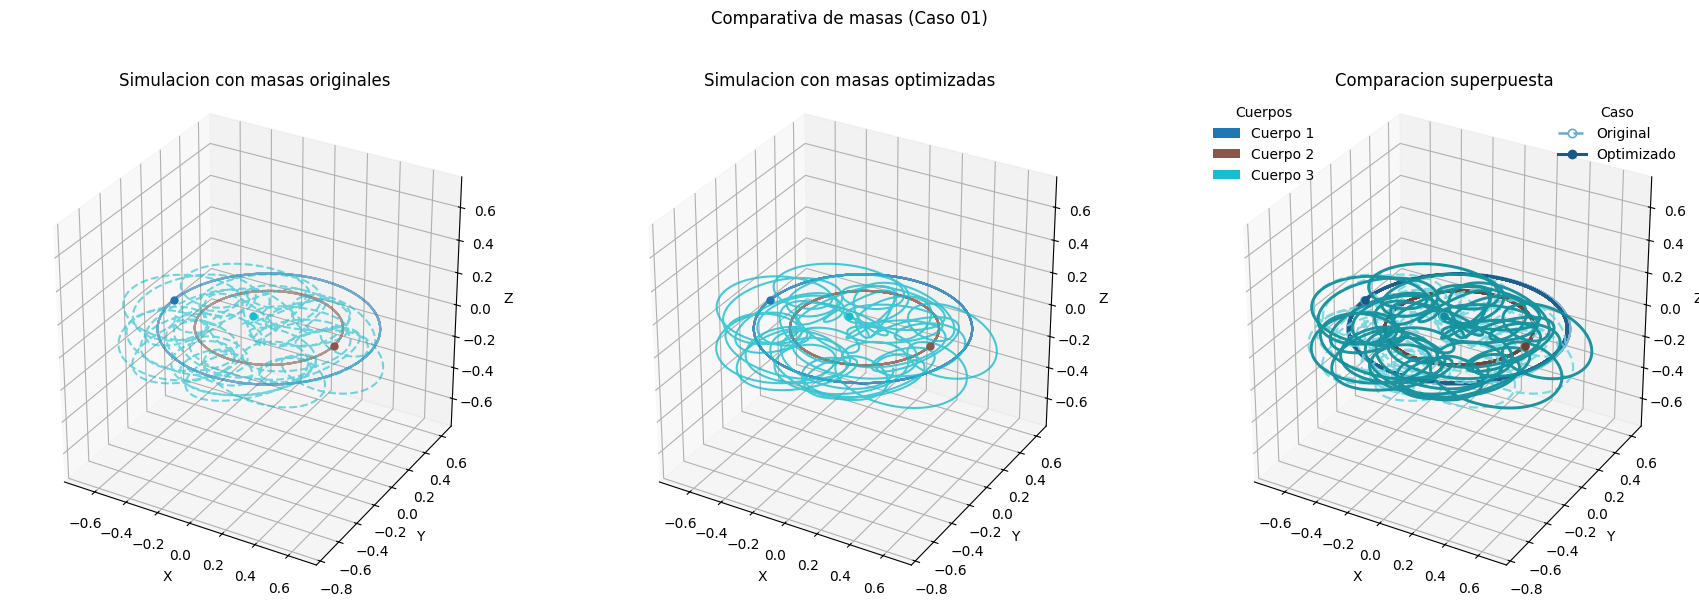

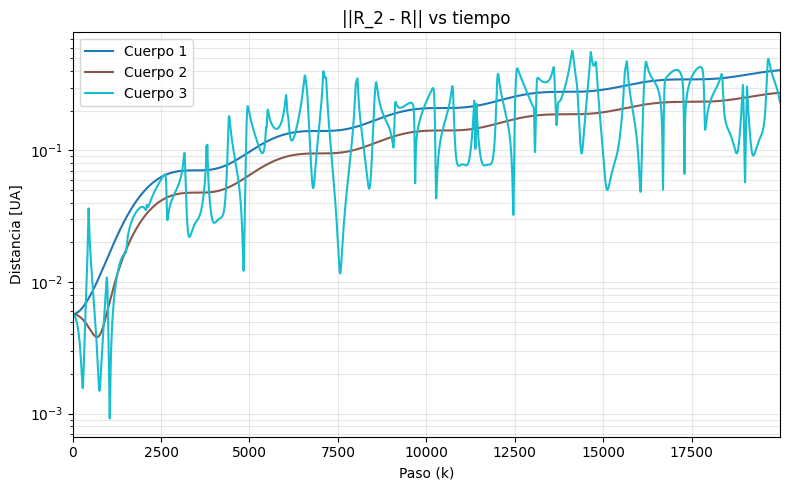

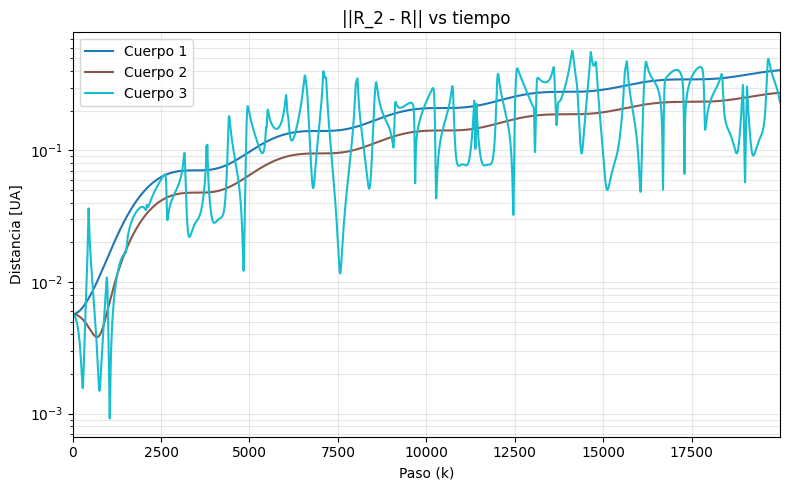

In [21]:
orig_tracks = [traj_original[:, i, :3] for i in range(traj_original.shape[1])]
opt_tracks = [traj_opt[:, i, :3] for i in range(traj_opt.shape[1])]

anim_mass = viz_3d.plot_mass_comparison(
    original_tracks=orig_tracks,
    optimized_tracks=opt_tracks,
    original_masses=center,          # opcional, útil para etiquetar/distancias
    optimized_masses=best_masses,    # idem
    body_labels=[f"Cuerpo {i+1}" for i in range(len(opt_tracks))],
    dt=cfg.dt,                       # usa tu paso real si quieres la etiqueta temporal
    title="Comparativa de masas (Caso 01)",
)

if anim_mass is not None:
    dist_fig = viz_3d.plot_mass_distance_evolution(
        comparison_data=anim_mass.mass_comparison_data,
        title="||R_2 - R|| vs tiempo",
    )
    if dist_fig is not None:
        display(dist_fig)
    # display(HTML(anim_mass.to_jshtml()))  # descomenta para ver la animación embebida


In [22]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

## Reporte de tiempos

Leemos el CSV más reciente generado por la instrumentación, mostramos las primeras filas y podemos agregar estadísticas por sección para identificar cuellos de botella del pipeline en este escenario.


In [23]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

'Usando CSV: C:\\Users\\emicr\\Documents\\CODIGOS_FUENTES\\TrabajoTerminal\\collision_of_two_bodies\\two_body\\data\\timings\\timings_ddf0b833-a5c4-4572-b8c0-19a388d2f328_20251103_000322.csv'

,run_id,epoch,batch_id,individual_id,section,start_ns,end_ns,duration_us,extra
0,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689749600,19529689791500,41,"{'step': 0, 'dt': 0.0002, 't_target': 0.0002}"
1,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689823000,19529689841300,18,"{'step': 1, 'dt': 0.0002, 't_target': 0.0004}"
2,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689854900,19529689868200,13,"{'step': 2, 'dt': 0.0002, 't_target': 0.000600..."
3,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689878500,19529689890900,12,"{'step': 3, 'dt': 0.0002, 't_target': 0.0008}"
4,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689898600,19529689910900,12,"{'step': 4, 'dt': 0.0002, 't_target': 0.001}"
5,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689918600,19529689931400,12,"{'step': 5, 'dt': 0.0002, 't_target': 0.001200..."
6,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689938900,19529689951000,12,"{'step': 6, 'dt': 0.0002, 't_target': 0.0014}"
7,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689958000,19529689971200,13,"{'step': 7, 'dt': 0.0002, 't_target': 0.0016}"
8,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689977700,19529689989400,11,"{'step': 8, 'dt': 0.0002, 't_target': 0.001800..."
9,ddf0b833-a5c4-4572-b8c0-19a388d2f328,0,0,0,simulation_step,19529689996600,19529690008400,11,"{'step': 9, 'dt': 0.0002, 't_target': 0.002}"


,count,mean,sum
section,,,
notebook_run,1,1.096908e+09,1096907618
batch_eval,101,1.083186e+07,1094018184
fitness_eval,9601,1.139131e+05,1093680126
lyapunov_compute,9593,1.137711e+05,1091406360
simulation_step,34559992,1.975024e+01,682568261
ga_main,50,5.628382e+04,2814191
crossover,1170,6.534650e+02,764554
selection_tournament,1170,2.775957e+02,324787
mutation,1170,1.874342e+02,219298


In [ ]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"


Ejecutando: c:\Users\emicr\anaconda3\envs\grav2body\python.exe scripts/plot_timings.py --run-id ddf0b833-a5c4-4572-b8c0-19a388d2f328 --top-n 5


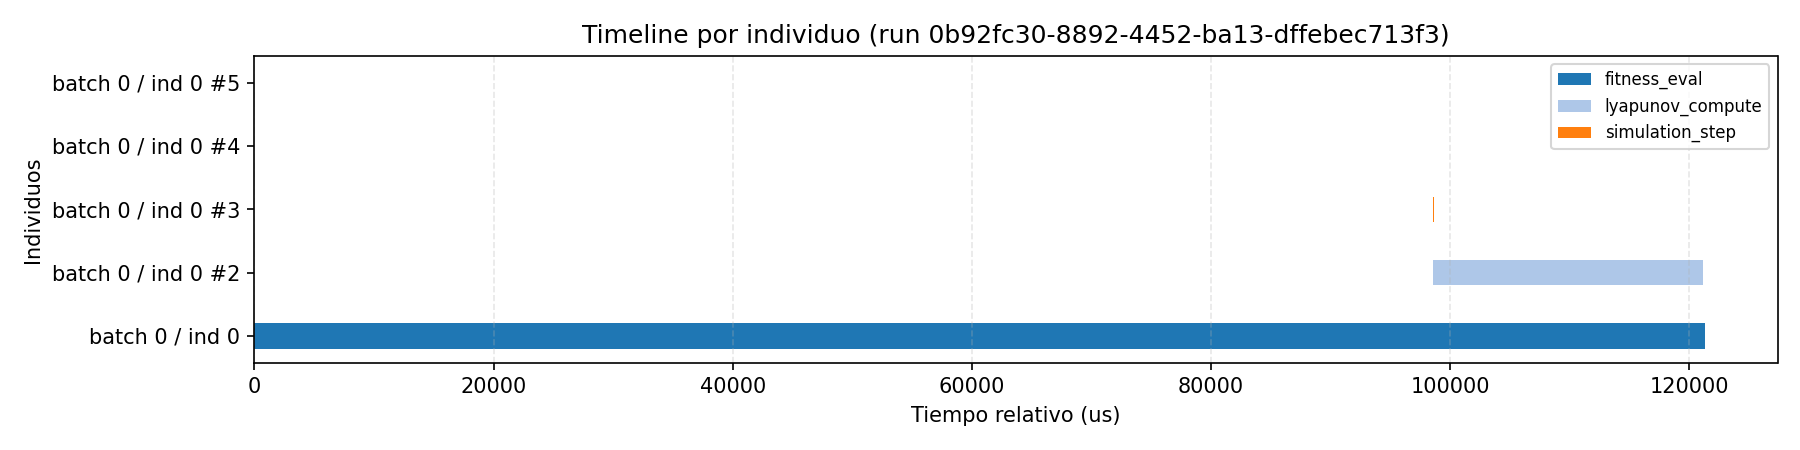

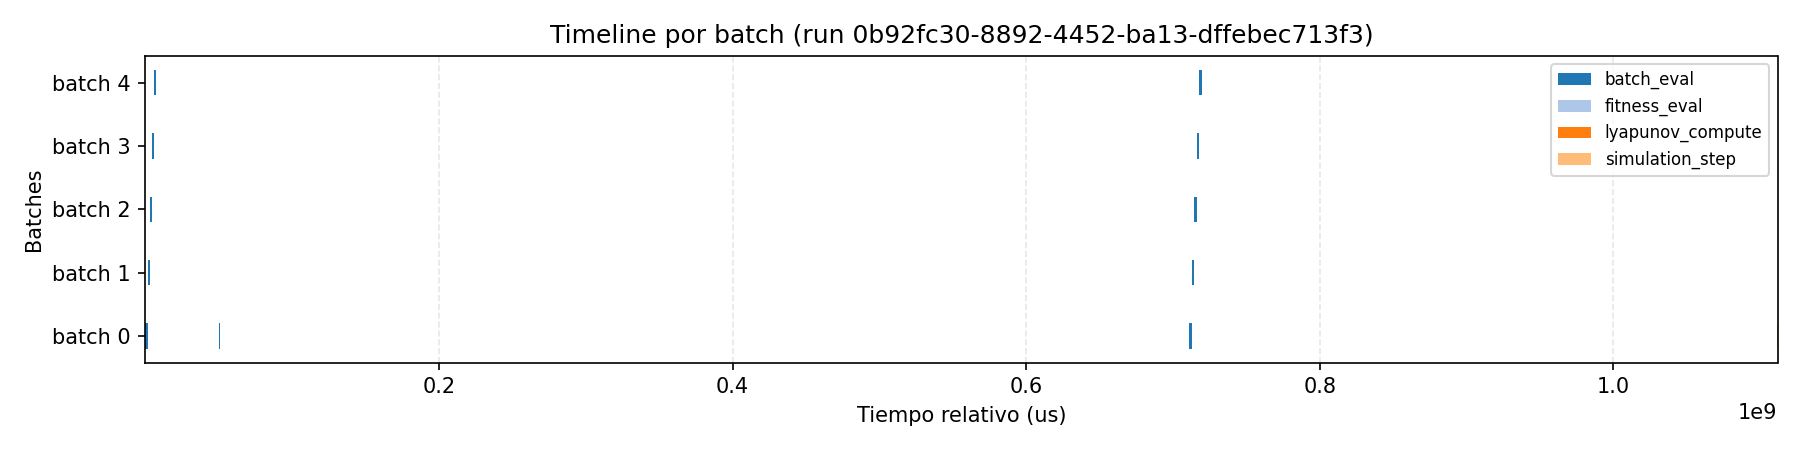

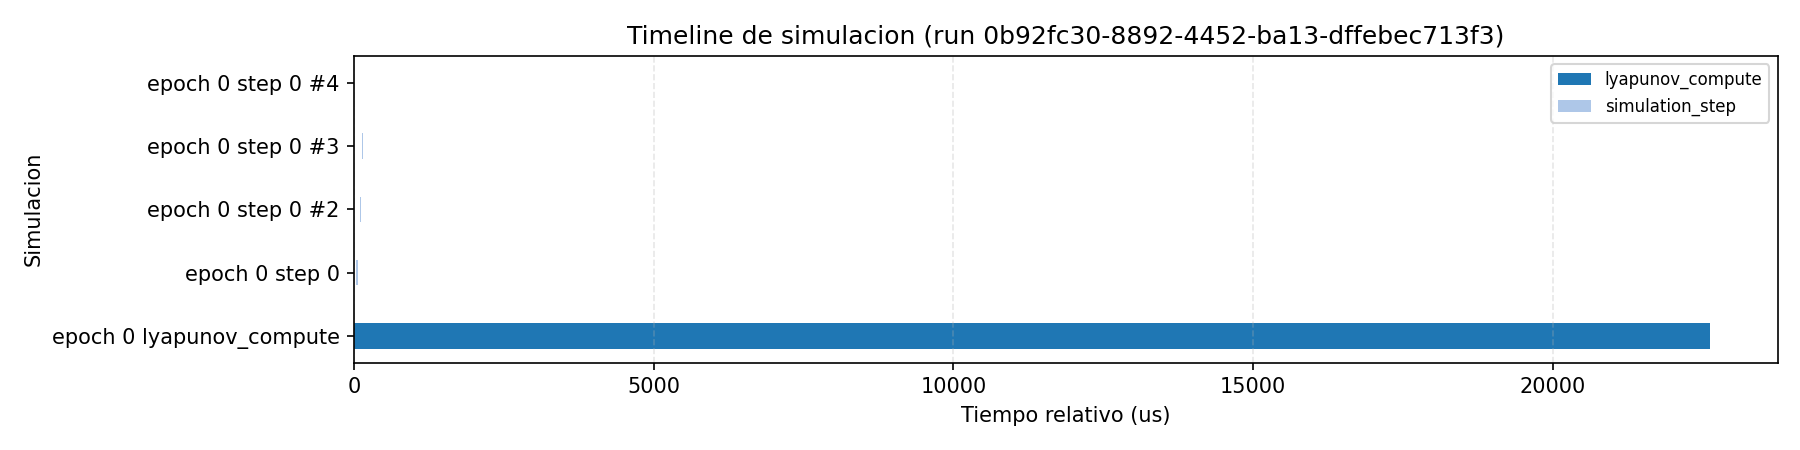

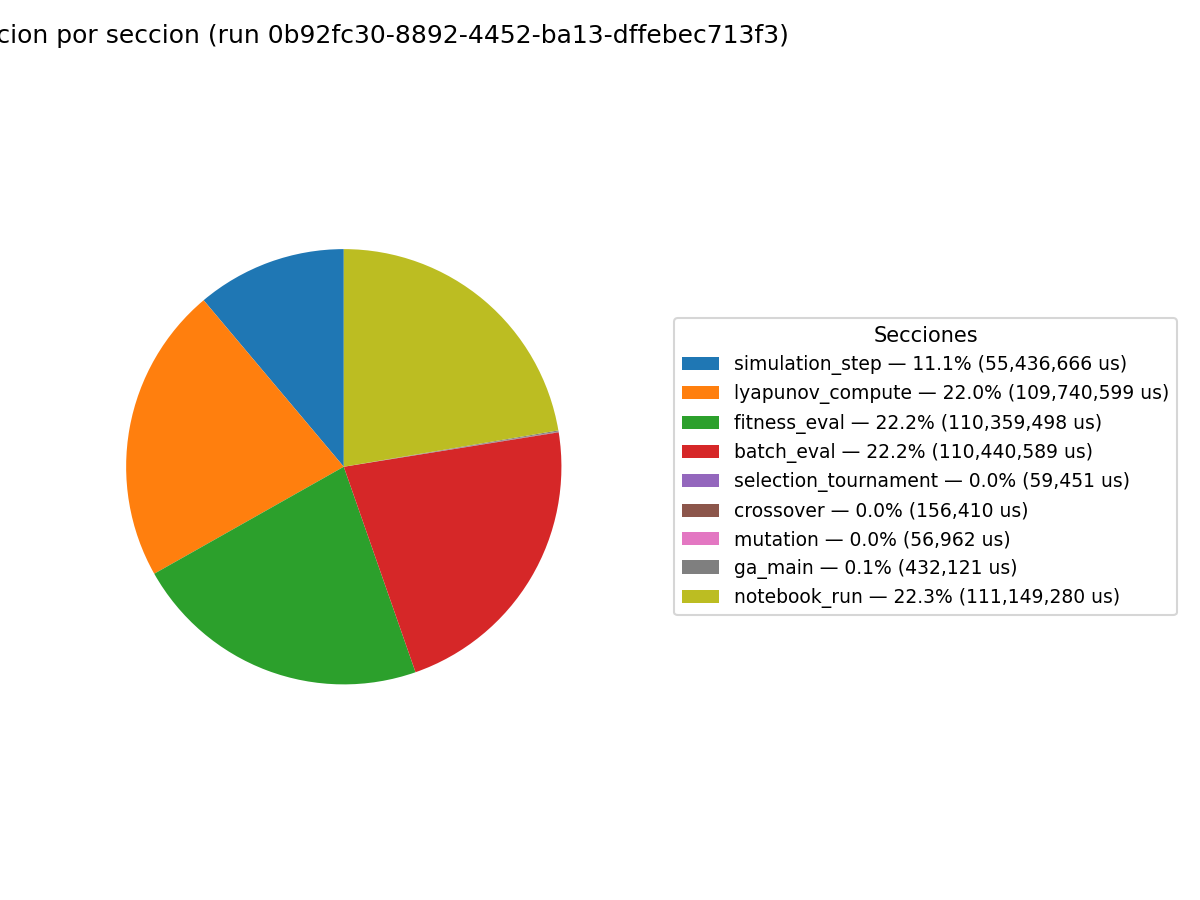

In [ ]:
display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)